In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# For producing decision tree diagrams.
from IPython.display import Image, display
import pydotplus

# For decision tree visualization
from subprocess import call

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/accepted_2007_to_2018Q4.csv', engine='c')
# Data Dictionary source - LoanStats tab
# https://resources.lendingclub.com/LCDataDictionary.xlsx
# https://help.lendingclub.com/hc/en-us/articles/115004323368-Recent-and-upcoming-changes-to-the-downloadable-data-files-and-API-services

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Feature Engineering

In [ ]:
def remove_invalid_rows(df):
  """Removing summary data and selecting records which are either 'Fully Paid' or 'Charged Off'"""
  # Removing summary rows which has empty member ID
  df = df[df.loan_amnt.notnull()]
  # Removing loans other than "Fully Paid" and "Charged Off" status
  df = df[(df.loan_status == 'Fully Paid') | (df.loan_status == 'Charged Off')]

  return df


def remove_features(df):
  """Removing features that do not have values like id and features
  that are only available after the loan is administered
  """
  # We need to revisit the importance of these features
  optional_list = ['earliest_cr_line', 'zip_code', 'emp_title', 'desc', 'title', 'zip_code', 'addr_state']
  # These features are identifications without any value
  identity = ['id', 'member_id', 'url']
  # These features have the same value for the whole records
  constant = ['policy_code', 'pymnt_plan', 'out_prncp', 'out_prncp_inv']
  # The following features are available only after the loan is issued
  # So, the features won't be available during in production prediction envirnoment
  # making it irrelevant for traning
  debt_settlement = ['debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status',
                   'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']
  hardship_program = ['hardship_flag', 'hardship_type', 'hardship_reason',
                      'hardship_status', 'deferral_term', 'hardship_amount',
                      'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
                      'hardship_length', 'hardship_dpd', 'hardship_loan_status',
                      'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
                      'hardship_last_payment_amount']
  fico_change = ['last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low']
  loan_payment = ['last_pymnt_d', 'next_pymnt_d', 'last_pymnt_amnt']
  collection = ['collection_recovery_fee', 'recoveries']
  fund = ['funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
          'total_rec_late_fee', 'total_rec_prncp']
  # There is only 1.38% data available for the following features; secondary applicant
  # We belive these won't add any value as the rest of the rows needs to be filled with fake data
  secondary = ['sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line',
               'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
               'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
               'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
               'sec_app_mths_since_last_major_derog', 'dti_joint', 'annual_inc_joint',
               'revol_bal_joint', 'verification_status_joint']
  # Merging together all features that will be removed
  features = identity + optional_list + debt_settlement + hardship_program \
             + fico_change + loan_payment + collection + fund + secondary + constant
  df = df.drop(features, axis=1)
  return df

# Label encoding
def encode_ordinal(df, features):
  """Encoding ordinal data"""
  scale_mapper = {
      'sub_grade': {},
      'grade': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F':6, 'G':7},
      'emp_length': {'0 year':1,'< 1 year':2,'1 year':3,'2 years':4,'3 years':5,'4 years':6,
          '5 years':7,'6 years':8,'7 years':9,'8 years':10,'9 years':11,'10+ years':12}
  }
  count = 1
  for grade, val in scale_mapper['grade'].items():
    for i in range(1, 6, 1):
      scale_mapper['sub_grade']["%s%s"%(grade, i)] = count
      count += 1

  for feature, mapper in scale_mapper.items():
    df[feature] = df[feature].replace(mapper)
  
  return df


def split_data(df):
  """
  Split the dataset into 70% training 20% development 10% test data
  The split is done by chronological order
  Train data = June 2007  <-> April 2016
  Dev data   = April 2016 <-> July 2017
  Test data  = July 2017  <-> December 2018
  """
  df = df.sort_values(by='issue_d', ascending=True).reset_index(drop=True)
  train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)
  dev_data, test_data = train_test_split(test_data, test_size=0.33, shuffle=False)
  dev_data = dev_data.reset_index(drop=True)
  test_data = test_data.reset_index(drop=True)

  train_data = train_data.drop(['issue_d'], axis=1)
  dev_data = dev_data.drop(['issue_d'], axis=1)
  test_data = test_data.drop(['issue_d'], axis=1)
  return (train_data, dev_data, test_data)


def get_ML(df, label):
  """Split the data into Matrix and Label"""
  L = df[label]
  M = df.drop([label], axis=1)
  return M, L

In [ ]:
class Encoders:
  """Builds and maintains one-hot feature encoding"""
  one_hot = {} # It stores list of transformers that map feature-value to vectors
  droped_column = {} # Dropped column for each feature encoding

  def fit(self, df, features):
    """Learn a map from a feature value to indices"""
    for feature in features:
      self.droped_column[feature] = np.sort(df[feature].unique())[0]
      records = df[[feature]].to_dict('records')
      self.one_hot[feature] = DictVectorizer(sparse=False)
      self.one_hot[feature].fit(records)

  def transform(self, df):
    """Transforms feature values to array and merge it to original dataframe"""
    for feature, encoder in self.one_hot.items():
      records = df[[feature]].to_dict('records')
      one_hot = encoder.transform(records)
      names = self.names(feature)
      new_cols = pd.DataFrame(one_hot, columns=names)
      df = df.drop([feature], axis=1)
      df = pd.concat([df, new_cols], axis=1)
    # Dropping one column for each feature as it will be repetitive info
    for feature, value in self.droped_column.items():
      df = df.drop([feature+"="+value], axis=1)
    return df

  def fit_transform(self, df, features):
    """It performes fit first and then transform on the data"""
    self.fit(df, features)
    return self.transform(df)
  
  def vocabulary(self, feature):
    return self.one_hot[feature].vocabulary_
  
  def names(self, feature):
    return self.one_hot[feature].get_feature_names()



class FillNan:
  """It handles nan values"""
  values = {} # It keeps track of values used to replace a Nan

  def fit(self, df, avg = "mean"):
    """Keep track of values that will replace Nan"""
    for feature, data_type in df.dtypes.to_dict().items():
      if df[feature].isnull().sum() > 0 and data_type != np.object:
        self.values[feature] = round(df[feature].mean()) if avg == "mean" else round(df[feature].median())
    self.values['emp_length'] = '0 year' # Those are with 0 annual income
    self.values['dti'] = 0 # Those are with 0 annual income

  def transform(self, df):
    """Replace Nan values"""
    for feature, value in self.values.items():
      df[feature].fillna(value=value, inplace=True)
    return df
  
  def fit_transform(self, df, avg = "mean"):
    self.fit(df, avg)
    return self.transform(df)

# Initialing encorder and NaN handler
encoders = Encoders()
fillNan = FillNan()

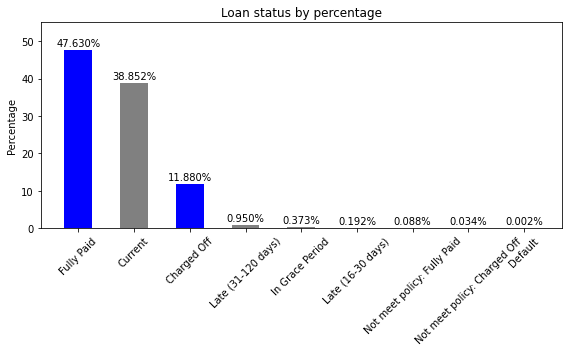

In [ ]:
loan_status_summary = df['loan_status'].value_counts().rename_axis('unique_values').reset_index(name='counts')
loan_status_summary['percent'] = (100. * (loan_status_summary['counts'] / loan_status_summary['counts'].sum())).round(3)
loan_status_summary['unique_values'] = loan_status_summary['unique_values'].replace(
    ['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'],
    ['Not meet policy: Fully Paid', 'Not meet policy: Charged Off'])
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True
width = 0.5
fig, ax = plt.subplots()
pps = ax.bar(loan_status_summary['unique_values'], loan_status_summary['percent'],
             width, align='center', color=['blue', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'])
ax.set_ylim([0,55])
plt.xticks(rotation=45)
for p in pps:
  percentage = p.get_height()
  ax.text(x=p.get_x() + p.get_width() / 2, y=percentage+1,
     s="{:.3f}%".format(percentage), ha='center')
ax.set_title("Loan status by percentage")
ax.set_ylabel("Percentage")
plt.show()

In [ ]:
df

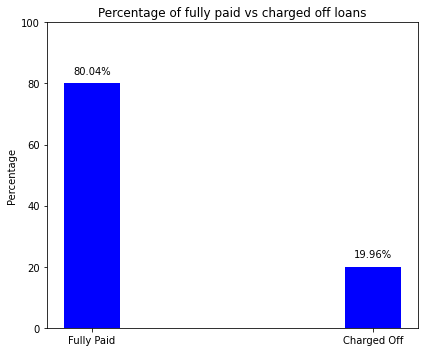

In [ ]:
df_clean = remove_invalid_rows(df)
status_count = df_clean['loan_status'].value_counts()
plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["figure.autolayout"] = True
fully_paid = ((status_count['Fully Paid']/len(df_clean))*100)
charged_off = ((status_count['Charged Off']/len(df_clean))*100)
y = [fully_paid, charged_off]
x = ['Fully Paid', 'Charged Off']
width = 0.2
fig, ax = plt.subplots()
pps = ax.bar(x, y, width, align='center', color=['blue', 'blue'])
ax.set_ylim([0,100])
for p in pps:
  percentage = p.get_height()
  ax.text(x=p.get_x() + p.get_width() / 2, y=percentage+3,
     s="{:.2f}%".format(percentage), ha='center')
ax.set_title("Percentage of fully paid vs charged off loans")
ax.set_ylabel("Percentage")
plt.show()

In [ ]:
print("Original data size =", df.shape)

# Cleanup work
df_clean = remove_invalid_rows(df)
df_clean = remove_features(df_clean)
print("After cleanup =", df_clean.shape)

# Splitting the data into training, dev and test
train_data, dev_data, test_data = split_data(df_clean)

# Handle NaN values
train_data = fillNan.fit_transform(train_data, avg="mean")
dev_data = fillNan.transform(dev_data)
test_data = fillNan.transform(test_data)

# Encode categorical features
encode_features = ['home_ownership', 'verification_status', 'purpose',
                   'application_type', 'term', 'grade', 'sub_grade', 'emp_length',
                   'initial_list_status', 'disbursement_method', 'loan_status']
train_data = encoders.fit_transform(train_data, encode_features)
dev_data = encoders.transform(dev_data)
test_data = encoders.transform(test_data)
print("After encoding =", train_data.shape)

# Splitting into Matrix and Label
train_data, train_label = get_ML(train_data, 'loan_status=Fully Paid')
dev_data, dev_label = get_ML(dev_data, 'loan_status=Fully Paid')

# Sample data
pd.set_option('display.max_columns', None)
train_data[:3]

Original data size = (2260701, 151)
After cleanup = (1345310, 85)
After encoding = (941717, 149)


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OTHER,home_ownership=OWN,home_ownership=RENT,verification_status=Source Verified,verification_status=Verified,purpose=credit_card,purpose=debt_consolidation,purpose=educational,purpose=home_improvement,purpose=house,purpose=major_purchase,purpose=medical,purpose=moving,purpose=other,purpose=renewable_energy,purpose=small_business,purpose=vacation,purpose=wedding,application_type=Joint App,term= 60 months,grade=B,grade=C,grade=D,grade=E,grade=F,grade=G,sub_grade=A2,sub_grade=A3,sub_grade=A4,sub_grade=A5,sub_grade=B1,sub_grade=B2,sub_grade=B3,sub_grade=B4,sub_grade=B5,sub_grade=C1,sub_grade=C2,sub_grade=C3,sub_grade=C4,sub_grade=C5,sub_grade=D1,sub_grade=D2,sub_grade=D3,sub_grade=D4,sub_grade=D5,sub_grade=E1,sub_grade=E2,sub_grade=E3,sub_grade=E4,sub_grade=E5,sub_grade=F1,sub_grade=F2,sub_grade=F3,sub_grade=F4,sub_grade=F5,sub_grade=G1,sub_grade=G2,sub_grade=G3,sub_grade=G4,sub_grade=G5,emp_length=1 year,emp_length=10+ years,emp_length=2 years,emp_length=3 years,emp_length=4 years,emp_length=5 years,emp_length=6 years,emp_length=7 years,emp_length=8 years,emp_length=9 years,emp_length=< 1 year,initial_list_status=w,disbursement_method=DirectPay
0,20000.0,9.45,640.20,93492.0,3.98,0.0,775.0,779.0,0.0,34.0,71.0,9.0,0.0,32.0,0.3,17.0,0.0,44.0,0.0,258.0,141327.0,1.0,3.0,1.0,2.0,20.0,35720.0,71.0,1.0,3.0,5593.0,58.0,32773.0,1.0,2.0,2.0,5.0,13490.0,10126.0,60.0,0.0,0.0,126.0,182.0,13.0,8.0,2.0,24.0,40.0,7.0,36.0,1.0,4.0,6.0,5.0,8.0,9.0,8.0,15.0,6.0,12.0,0.0,0.0,0.0,2.0,94.0,45.0,0.0,0.0,174530.0,49607.0,21605.0,42109.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6400.0,12.29,213.46,35000.0,20.78,0.0,685.0,689.0,1.0,26.0,71.0,5.0,0.0,9408.0,64.0,12.0,0.0,44.0,0.0,258.0,141327.0,1.0,3.0,1.0,2.0,20.0,35720.0,71.0,1.0,3.0,5593.0,58.0,32773.0,1.0,2.0,2.0,5.0,13490.0,10126.0,60.0,0.0,0.0,126.0,182.0,13.0,8.0,2.0,24.0,40.0,7.0,36.0,1.0,4.0,6.0,5.0,8.0,9.0,8.0,15.0,6.0,12.0,0.0,0.0,0.0,2.0,94.0,45.0,0.0,0.0,174530.0,49607.0,21605.0,42109.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9600.0,11.66,185.10,60000.0,21.52,0.0,705.0,709.0,1.0,34.0,71.0,24.0,0.0,39010.0,34.2,51.0,0.0,44.0,0.0,258.0,141327.0,1.0,3.0,1.0,2.0,20.0,35720.0,71.0,1.0,3.0,5593.0,58.0,32773.0,1.0,2.0,2.0,5.0,13490.0,10126.0,60.0,0.0,0.0,126.0,182.0,13.0,8.0,2.0,24.0,40.0,7.0,36.0,1.0,4.0,6.0,5.0,8.0,9.0,8.0,15.0,6.0,12.0,0.0,0.0,0.

# k-Nearest Neigbors models

In [ ]:
def BuildKNN():
  """Building a K-NN model"""
  neighbors, f1, precision, recall = [], [], [], []
  for n in range(3, 5, 2):
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(train_data, train_label)
    dev_predict = knn_model.predict(dev_data)
    neighbors.append(n)
    f1.append(round(metrics.f1_score(dev_label, dev_predict), 3))
    precision.append(round(metrics.precision_score(dev_label, dev_predict), 3))
    recall.append(round(metrics.recall_score(dev_label, dev_predict), 3))
  
  accuracy = pd.DataFrame({'Neighbors': neighbors, 'F1': f1,
                           'Precision': precision, 'Recall': recall})
  print("Score for different neighbors")
  print(accuracy)

BuildKNN()

KeyboardInterrupt: ignored

# Gaussian Naive Bayes (GaussianNB)

In [ ]:
def BuildGaussian():
  """Building a Gaussian Naive Bayes (GaussianNB) model"""
  smoothing, f1, precision, recall = [], [], [], []
  for s in [0.001, 0.01, 0.05, 1, 10]:
    clf = GaussianNB(var_smoothing=s)
    clf.fit(train_data, train_label)
    dev_predict = clf.predict(dev_data)
    smoothing.append(s)
    f1.append(round(metrics.f1_score(dev_label, dev_predict), 3))
    precision.append(round(metrics.precision_score(dev_label, dev_predict), 3))
    recall.append(round(metrics.recall_score(dev_label, dev_predict), 3))
  
  accuracy = pd.DataFrame({'Smoothing': smoothing, 'F1': f1,
                           'Precision': precision, 'Recall': recall})
  print("Score for different smoothing")
  print(accuracy)

BuildGaussian()

Score for different smoothing
   Smoothing     F1  Precision  Recall
0      0.001  0.427      0.855   0.284
1      0.010  0.676      0.834   0.568
2      0.050  0.890      0.802   1.000
3      1.000  0.890      0.802   1.000
4     10.000  0.890      0.802   1.000


# Logistic Regression

### Without standardization

In [ ]:
cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0, 1000.0]
for c in cs:
  lr_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", tol=0.015)
  lr_model.fit(train_data, train_label)
  dev_predict = lr_model.predict(dev_data)
  print("C =", c,
      "F1 =", metrics.f1_score(dev_label, dev_predict),
      "Precision =", metrics.precision_score(dev_label, dev_predict),
      "Recall =", metrics.recall_score(dev_label, dev_predict))

C = 1e-05 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 0.0001 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 0.001 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 0.01 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 0.1 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 0.5 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 1.0 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 2.0 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 10.0 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 100.0 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.9985205600671048
C = 1000.0 F1 = 0.8899244611852076 Precision = 0.8026325538662161 Recall = 0.99

### With standardization

In [ ]:
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_dev_data = scaler.transform(dev_data)
cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0, 1000.0]
for c in cs:
  lr_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", tol=0.015)
  lr_model.fit(scaled_train_data, train_label)
  dev_predict = lr_model.predict(scaled_dev_data)
  print("C =", c,
      "F1 =", metrics.f1_score(dev_label, dev_predict),
      "Precision =", metrics.precision_score(dev_label, dev_predict),
      "Recall =", metrics.recall_score(dev_label, dev_predict))

C = 1e-05 F1 = 0.8882175099373443 Precision = 0.8175944372524244 Recall = 0.9721948251864279
C = 0.0001 F1 = 0.8904348043359666 Precision = 0.8121182887180578 Recall = 0.9854683049581977
C = 0.001 F1 = 0.890627276776979 Precision = 0.8121099385012528 Recall = 0.9859522339082102
C = 0.01 F1 = 0.8905789377258874 Precision = 0.8121577800223274 Recall = 0.9857632711753482
C = 0.1 F1 = 0.8905387595850155 Precision = 0.8121503951270824 Recall = 0.9856757030796317
C = 0.5 F1 = 0.8905410694804168 Precision = 0.8121511084782064 Recall = 0.9856803119267746
C = 1.0 F1 = 0.8905429235884549 Precision = 0.8121541926002438 Recall = 0.9856803119267746
C = 2.0 F1 = 0.8905429235884549 Precision = 0.8121541926002438 Recall = 0.9856803119267746
C = 10.0 F1 = 0.8905447777042137 Precision = 0.812157276745705 Recall = 0.9856803119267746
C = 100.0 F1 = 0.8905447777042137 Precision = 0.812157276745705 Recall = 0.9856803119267746
C = 1000.0 F1 = 0.8905447777042137 Precision = 0.812157276745705 Recall = 0.985680

### Using L1 for feature selection

<class 'numpy.ndarray'>
148


,L1 C,L2 C,Feature Size,F1 Score,Precision,Recall
1,0.0001,0.0001,13.0,0.889,0.811,0.984
2,0.0001,0.0010,13.0,0.889,0.812,0.984
3,0.0001,0.0100,13.0,0.889,0.812,0.984
4,0.0001,1.0000,13.0,0.889,0.812,0.984
5,0.0010,0.0001,87.0,0.890,0.812,0.986
6,0.0010,0.0010,87.0,0.890,0.812,0.985
7,0.0010,0.0100,87.0,0.890,0.812,0.985
8,0.0010,1.0000,87.0,0.890,0.812,0.985
9,0.0100,0.0001,139.0,0.890,0.812,0.986
10,0.0100,0.0010,139.0,0.891,0.812,0.986


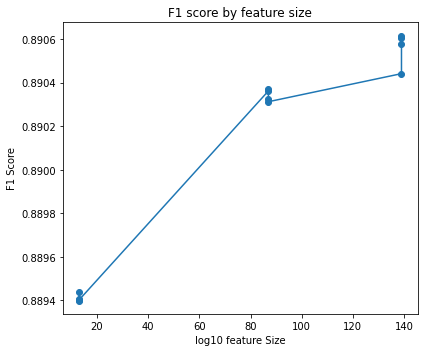

In [ ]:
np.random.seed(0)

# Intitializing regularization and result variables
regularization = [0.0001, 0.001, 0.01] #, 0.5, 1, 10, 25, 50, 100, 150, 500, 1000]
#regularization = [0.5]
regularizations1 = []
regularizations2 = []
f1_scores = []
feature_size = []
precisions = []
recalls = []
print(type(scaled_train_data))
print(scaled_train_data.shape[1])
# Evaluating Logistic Regression for each regularization C
for i, c in enumerate(regularization):
    lr_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
    lr_model.fit(scaled_train_data, train_label)
    new_features = []
    # Identifying features with 0 weight across all topics
    for index in range(0, scaled_train_data.shape[1]):
        if np.any(lr_model.coef_[:,index]): # Check if the feature has non-zero weight
            new_features.append(index)
    #print(c, "=", len(new_features))

    scaled_train_data_reduced = scaled_train_data[:,new_features]
    scaled_dev_data_reduced = scaled_dev_data[:,new_features]
    
    for c2 in [0.0001, 0.001, 0.01, 1]:
      # Building Logistic Regression based on the newly identified features
      lr_model_l2 = LogisticRegression(C=c2, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015)
      lr_model_l2.fit(scaled_train_data_reduced, train_label)
      dev_predict = lr_model_l2.predict(scaled_dev_data_reduced)
      
      # Measuring scores along with the feature size
      regularizations1.append(c)
      regularizations2.append(c2)
      feature_size.append(len(new_features))
      f1_scores.append(metrics.f1_score(dev_label, dev_predict))
      precisions.append(metrics.precision_score(dev_label, dev_predict))
      recalls.append(metrics.recall_score(dev_label, dev_predict))

# Building pandas dataframe to display results in table format
lr_summary = pd.DataFrame(data=np.column_stack((regularizations1, regularizations2, feature_size,
                                                np.array(f1_scores).round(3), np.array(precisions).round(3), np.array(recalls).round(3))),
                          columns=["L1 C", "L2 C", "Feature Size", "F1 Score", "Precision", "Recall"])
lr_summary.index = lr_summary.index + 1 # Starting the index from 1
display(lr_summary)

# GMM

In [ ]:
def GMM(train_data, train_label, dev_data, dev_label):
  charged_off = train_data[train_label == 0]
  fully_paid = train_data[train_label == 1]

  components = []
  c_types = []
  f1_scores = []
  precisions = []
  recalls = []
  covariance_types = ["tied", "full", "diag", "spherical"]
  for t in covariance_types:
    for n in range(11,16):
      try:
        gmm_charged_off = GaussianMixture(n_components=n, covariance_type=t, random_state=0)
        gmm_charged_off.fit(charged_off)
        gmm_fully_paid  = GaussianMixture(n_components=n, covariance_type=t, random_state=0)
        gmm_fully_paid.fit(fully_paid)
      except:
        continue

      charged_off_likelihood = gmm_charged_off.score_samples(dev_data)
      fully_paid_likelihood = gmm_fully_paid.score_samples(dev_data)
      predict_payment = fully_paid_likelihood > charged_off_likelihood

      components.append(n)
      c_types.append(t)
      f1_scores.append(metrics.f1_score(dev_label, predict_payment))
      precisions.append(metrics.precision_score(dev_label, predict_payment))
      recalls.append(metrics.recall_score(dev_label, predict_payment))

  lr_summary = pd.DataFrame(
      data=np.column_stack((components, c_types, np.array(f1_scores).round(3), np.array(precisions).round(3), np.array(recalls).round(3))),
      columns=["Components", "Covariance Type", "F1 Score", "Precision", "Recall"])
  display(lr_summary)

GMM(train_data, train_label, dev_data, dev_label)
# GMM 1 - 5
# 4 -> tied -> 0.802, 0.863, 0.749
# 4 -> full -> 0.865, 0.822, 0.912
# 5 -> tied	-> 0.813, 0.859, 0.771
# 5 -> diag -> 0.862, 0.825, 0.902
# 5 -> full -> 0.857, 0.827, 0.89
# 10 -> tied -> 0.832, 0.849, 0.816
# 10, 11, 12, 20 -> Singleton or collapsed samples
# 20 -> tied -> 0.834, 0.848, 0.821
# 11	tied	0.785	0.869	0.717
# 14	tied	0.807	0.859	0.761
# 15	tied	0.806	0.86	0.759

#### PCA GMM

In [28]:
def PCA_GMM(train_data, train_label, dev_data, dev_label):
  pca = PCA(n_components=20)
  train_data_2dm = pca.fit_transform(train_data)
  dev_data_2dm = pca.fit_transform(dev_data)

  charged_off = train_data_2dm[train_label == 0]
  fully_paid = train_data_2dm[train_label == 1]

  components = []
  c_types = []
  f1_scores = []
  precisions = []
  recalls = []
  covariance_types = ["tied", "full", "diag", "spherical"]
  for t in covariance_types:
    for n in range(5,6):
      try:
        gmm_charged_off = GaussianMixture(n_components=n, covariance_type=t, random_state=0)
        gmm_charged_off.fit(charged_off)
        gmm_fully_paid  = GaussianMixture(n_components=n, covariance_type=t, random_state=0)
        gmm_fully_paid.fit(fully_paid)
      except:
        continue

      charged_off_likelihood = gmm_charged_off.score_samples(dev_data_2dm)
      fully_paid_likelihood = gmm_fully_paid.score_samples(dev_data_2dm)
      predict_payment = fully_paid_likelihood > charged_off_likelihood

      components.append(n)
      c_types.append(t)
      f1_scores.append(metrics.f1_score(dev_label, predict_payment))
      precisions.append(metrics.precision_score(dev_label, predict_payment))
      recalls.append(metrics.recall_score(dev_label, predict_payment))

  lr_summary = pd.DataFrame(
      data=np.column_stack((components, c_types, np.array(f1_scores).round(3), np.array(precisions).round(3), np.array(recalls).round(3))),
      columns=["Components", "Covariance Type", "F1 Score", "Precision", "Recall"])
  display(lr_summary)

PCA_GMM(train_data, train_label, dev_data, dev_label)

,Components,Covariance Type,F1 Score,Precision,Recall
0,5,tied,0.658,0.832,0.545
1,5,diag,0.682,0.8,0.595
2,5,spherical,0.552,0.813,0.418


# Decision tree classifier

In [ ]:
encoders = Encoders()
fillNan = FillNan()
df_clean = remove_invalid_rows(df)
df_clean = remove_features(df_clean)
train_data, dev_data, test_data = split_data(df_clean)
encode_features = ['home_ownership', 'verification_status', 'purpose',
                   'application_type', 'term', 'initial_list_status',
                   'disbursement_method', 'loan_status']
train_data = fillNan.fit_transform(train_data, avg="mean")
dev_data = fillNan.transform(dev_data)
test_data = fillNan.transform(test_data)
train_data = encode_ordinal(train_data, ['grade', 'sub_grade', 'emp_length'])
dev_data = encode_ordinal(dev_data, ['grade', 'sub_grade', 'emp_length'])
test_data = encode_ordinal(test_data, ['grade', 'sub_grade', 'emp_length'])

train_data = encoders.fit_transform(train_data, encode_features)
dev_data = encoders.transform(dev_data)
test_data = encoders.transform(test_data)
train_data, train_label = get_ML(train_data, 'loan_status=Fully Paid')
dev_data, dev_label = get_ML(dev_data, 'loan_status=Fully Paid')

In [ ]:
def BuildDecisionTree():
  """Building a Decision tree classifier model"""
  depth, f1, precision, recall = [], [], [], []
  for d in range(1, 6, 1):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    dt.fit(train_data, train_label)
    dev_predict = dt.predict(dev_data)
    depth.append(d)
    f1.append(round(metrics.f1_score(dev_label, dev_predict), 3))
    precision.append(round(metrics.precision_score(dev_label, dev_predict), 3))
    recall.append(round(metrics.recall_score(dev_label, dev_predict), 3))
  
  accuracy = pd.DataFrame({'Depth': depth, 'F1': f1,
                           'Precision': precision, 'Recall': recall})
  print("Score for different depth")
  print(accuracy)
  #export_graphviz(dt, out_file='dot_data.dot')
  #call(['dot', '-Tpng', 'dot_data.dot', '-o', 'dot_data.png', '-Gdpi=600'])
  #display(Image(filename='dot_data.png'))

BuildDecisionTree()

Score for different depth
   Depth     F1  Precision  Recall
0      1  0.890      0.802   1.000
1      2  0.890      0.802   1.000
2      3  0.890      0.802   1.000
3      4  0.890      0.802   1.000
4      5  0.888      0.812   0.981


In [ ]:
# For each feature
# 1. Identify which feature to take/drop - DONE
# 2. Convert nominal features into separate features - DONE
# 3. Convert ordinal data to number - DONE
# 4. Convert date to number days/weeks/months data
# 5. Split the data - DONE
# 6. Replace NaN values for both training and dev separetly
# 7. Perform EDA
# 8. Build KNN and Decision Tree

# EDA
# Multi-Variate Analysis
#  - To understand the relationship among multivariate measurements and their structure
#  - https://seaborn.pydata.org/generated/seaborn.pairplot.html
# Correlation Analysis - Heatmap
#   It will be used to avoid collinearity which is needed for logestic regression, decsion tree (it can be mittigated vai random forest though)
#   https://towardsdatascience.com/feature-selection-and-eda-in-python-c6c4eb1058a3
#   https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b
# My suggestion
#   - Only show the output as a bar chart
#.  - Show sample records
#   - Show correlation heatmap and remove features with perfect collinearity for models that are explainable
#.  - Show sparsity of features and discuss the decision that we took. Remover, substitute, ...